# Logistic Regression with PySpark

In [98]:
import findspark
findspark.init()

In [99]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [100]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

In [ ]:
import os
os.getcwd()

In [102]:
from platform import python_version

print(python_version())

3.9.12


In [103]:
sc.version #spark version

'3.3.0'

## Read File

In [104]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("/Users/Downloads/lr/Pyspark/diabetes.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 768 rows 9 columns in the data.


## Show Sample Data

In [105]:
df.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 4 rows



## Data Types of Columns

In [106]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



## Statistics

In [107]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


from pyspark.sql.functions import when
df=df.withColumn("Glucose",when(df.Glucose==0,np.nan).otherwise(df.Glucose))
df=df.withColumn("BloodPressure",when(df.BloodPressure==0,np.nan).otherwise(df.BloodPressure))
df=df.withColumn("SkinThickness",when(df.SkinThickness==0,np.nan).otherwise(df.SkinThickness))
df=df.withColumn("BMI",when(df.BMI==0,np.nan).otherwise(df.BMI))
df=df.withColumn("Insulin",when(df.Insulin==0,np.nan).otherwise(df.Insulin))

In [108]:
from pyspark.sql.functions import when
df=df.withColumn("Glucose",when(df.Glucose==0,np.nan).otherwise(df.Glucose))
df=df.withColumn("BloodPressure",when(df.BloodPressure==0,np.nan).otherwise(df.BloodPressure))
df=df.withColumn("SkinThickness",when(df.SkinThickness==0,np.nan).otherwise(df.SkinThickness))
df=df.withColumn("BMI",when(df.BMI==0,np.nan).otherwise(df.BMI))
df=df.withColumn("Insulin",when(df.Insulin==0,np.nan).otherwise(df.Insulin))

from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"],outputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"])
model=imputer.fit(df)
raw_data=model.transform(df)
raw_data.show(5)

In [109]:
from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"],outputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"])
model=imputer.fit(df)
raw_data=model.transform(df)
raw_data.show(5)

+-----------+-------+-------------+------------------+-----------------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|     SkinThickness|          Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+------------------+-----------------+----+------------------------+---+-------+
|          6|  148.0|         72.0|              35.0|155.5482233502538|33.6|                   0.627| 50|      1|
|          1|   85.0|         66.0|              29.0|155.5482233502538|26.6|                   0.351| 31|      0|
|          8|  183.0|         64.0|29.153419593345657|155.5482233502538|23.3|                   0.672| 32|      1|
|          1|   89.0|         66.0|              23.0|             94.0|28.1|                   0.167| 21|      0|
|          0|  137.0|         40.0|              35.0|            168.0|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+------------------+-----------------+----+---

## Target Variable Distribution

In [110]:
df.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



## Distribution of Features

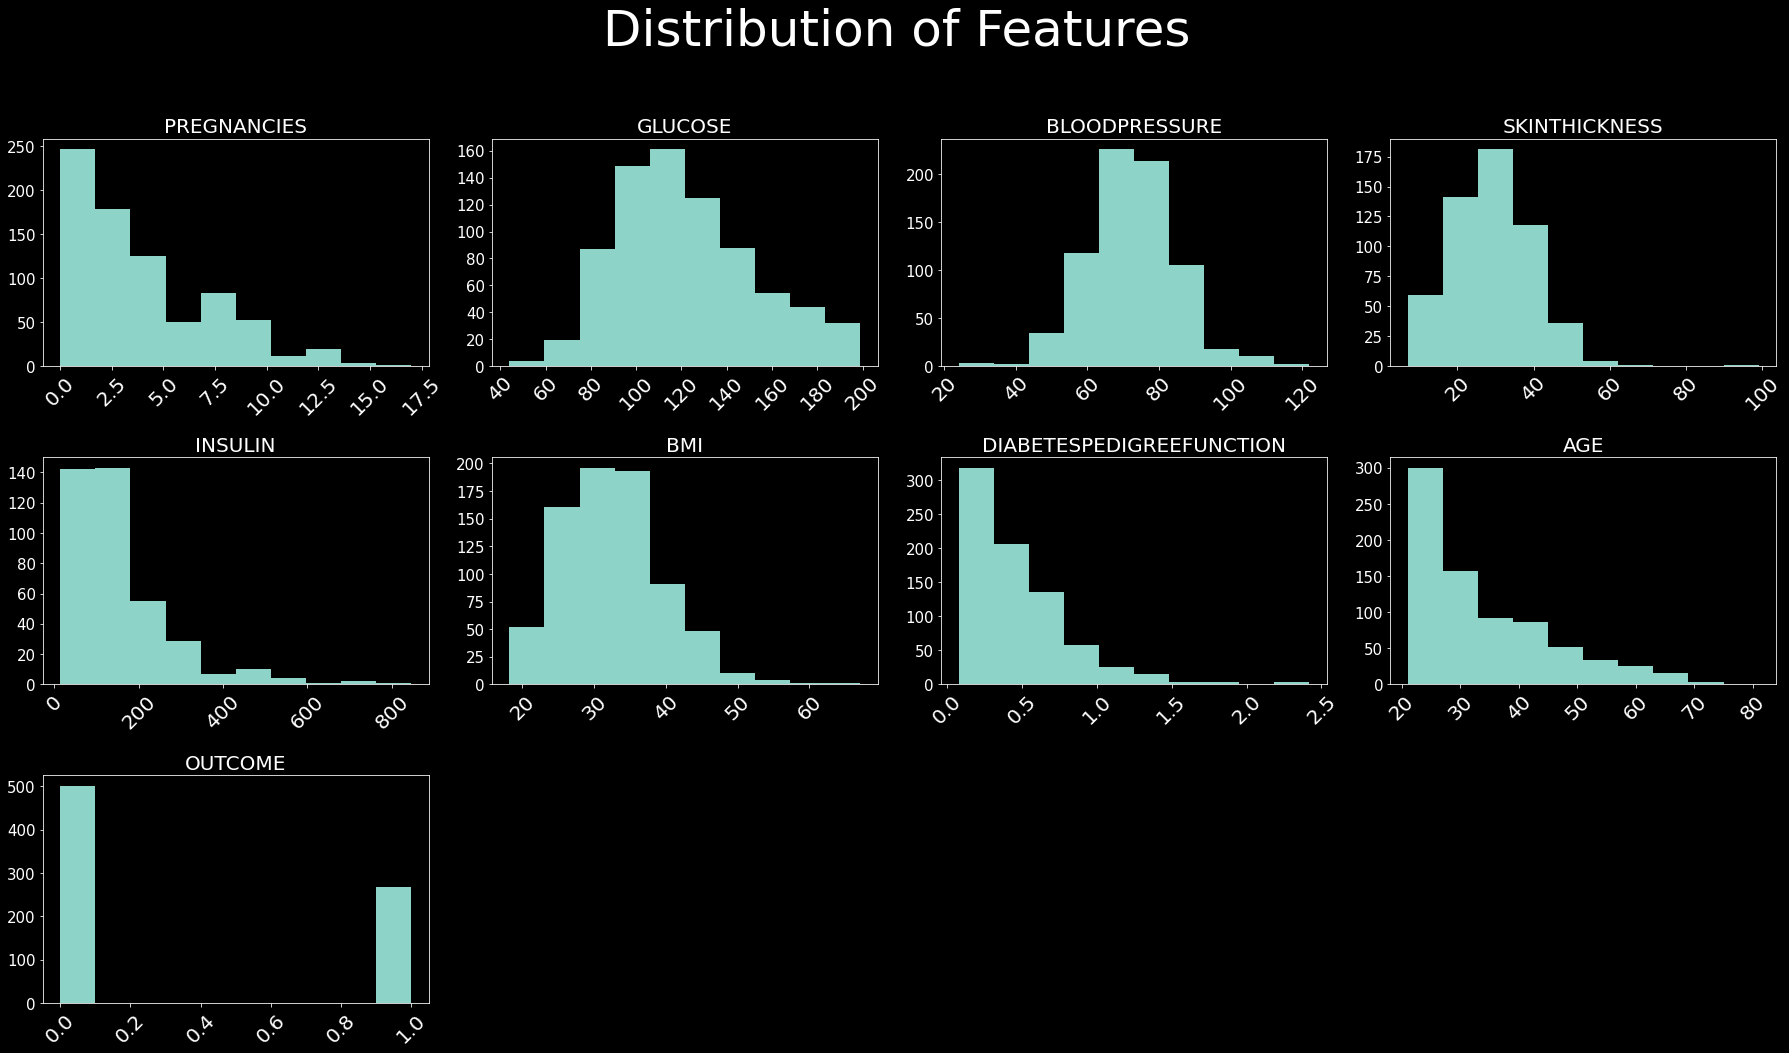

In [111]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

## Check For Null Values

In [112]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,5,35,227,374,11,0,0,0


In [113]:
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'Pregnancies': 0,
 'Glucose': 0,
 'BloodPressure': 0,
 'SkinThickness': 0,
 'Insulin': 0,
 'BMI': 0,
 'DiabetesPedigreeFunction': 0,
 'Age': 0,
 'Outcome': 0}

## UDF 
### a ) Change Column Name and Data of Target Variable(OutCome)  

In [114]:
from pyspark.sql.functions import udf
y_udf = udf(lambda y: "No" if y==0 else "yes", StringType())

df=df.withColumn("HasDiabities", y_udf('OutCome')).drop("OutCome")

### b) Create a new column - Age Groups

In [115]:
def udf_multiple(age):
      if (age <= 25):
        return 'Under 25'
      elif (age >= 25 and age <= 35):
        return 'Between 25 and 35'
      elif (age > 35 and age < 50):
        return 'Between 36 and 49'
      elif (age >= 50):
        return 'Over 50'
      else: return 'N/A'

education_udf = udf(udf_multiple)
df=df.withColumn("Age_udf", education_udf('Age'))

In [116]:
df.toPandas()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,HasDiabities,Age_udf
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,yes,Over 50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,No,Between 25 and 35
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,yes,Between 25 and 35
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,No,Under 25
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,yes,Between 25 and 35
...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,No,Over 50
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,No,Between 25 and 35
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,No,Between 25 and 35
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,yes,Between 36 and 49


### Age Groups Distribution

In [117]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
tab = df.select(['Age_udf','Glucose']).\
   groupBy('Age_udf').\
       agg(F.count('Glucose').alias('UserCount'),
           F.mean('Glucose').alias('Glucose_AVG'),
           F.min('Glucose').alias('Glucose_MIN'),
           F.max('Glucose').alias('Glucose_MAX')).\
       withColumn('total',sum(col('UserCount')).over(window)).\
       withColumn('Percent',col('UserCount')*100/col('total')).\
       drop(col('total')).sort(desc("Percent"))

In [118]:
tab.count()

4

In [119]:
tab.show()

22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 1

22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 19:10:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/04 1

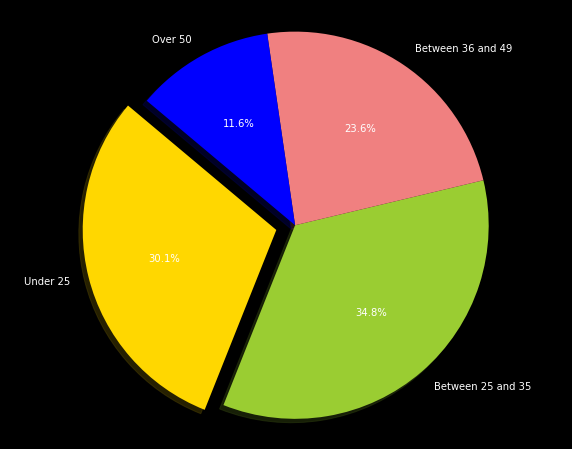

In [120]:
# Data to plot
labels = list(tab.select('Age_udf').distinct().toPandas()['Age_udf'])
sizes =  list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0.1, 0.0, 0 ,0.0 )  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Pearson Correlation

In [121]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [122]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,NaN,NaN,NaN,NaN,NaN,-0.033523,0.544341
Glucose,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
BloodPressure,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
SkinThickness,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Insulin,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
BMI,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
DiabetesPedigreeFunction,-0.033523,NaN,NaN,NaN,NaN,NaN,1.000000,0.033561
Age,0.544341,NaN,NaN,NaN,NaN,NaN,0.033561,1.000000


In [123]:
df=df.drop("Age")

In [124]:
df.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|HasDiabities|          Age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
|          6|  148.0|         72.0|         35.0|    NaN|33.6|                   0.627|         yes|          Over 50|
|          1|   85.0|         66.0|         29.0|    NaN|26.6|                   0.351|          No|Between 25 and 35|
|          8|  183.0|         64.0|          NaN|    NaN|23.3|                   0.672|         yes|Between 25 and 35|
|          1|   89.0|         66.0|         23.0|   94.0|28.1|                   0.167|          No|         Under 25|
+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
only showing top 4 rows



# Prepare Data for Machine Learning

## First Method 
### Step by Step apply 5 Estimators and Transformers and create new data frames

## a) StringIndexer

In [125]:
df2=df
df3=df

In [126]:
stringIndexer = StringIndexer()\
                 .setInputCol ("Age_udf")\
                 .setOutputCol ("Age_udfIndex")

Age_udfIndex_model=stringIndexer.fit(df2)
Age_udfIndex_df=Age_udfIndex_model.transform(df2)
Age_udfIndex_df.toPandas().head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex
0,6,148.0,72.0,35.0,NaN,33.6,0.627,yes,Over 50,3.0
1,1,85.0,66.0,29.0,NaN,26.6,0.351,No,Between 25 and 35,1.0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,yes,Between 25 and 35,1.0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,No,Under 25,0.0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,yes,Between 25 and 35,1.0
5,5,116.0,74.0,NaN,NaN,25.6,0.201,No,Between 25 and 35,1.0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,yes,Between 25 and 35,1.0
7,10,115.0,NaN,NaN,NaN,35.3,0.134,No,Between 25 and 35,1.0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,yes,Over 50,3.0
9,8,125.0,96.0,NaN,NaN,NaN,0.232,yes,Over 50,3.0


## b) OneHotEncoderEstimator

In [127]:
encoder = OneHotEncoder()\
         .setInputCols (["Age_udfIndex"])\
         .setOutputCols (["Age_encoded"])

encoder_model=encoder.fit(Age_udfIndex_df)
encoder_df=encoder_model.transform(Age_udfIndex_df)

encoder_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded
0,6,148.0,72.0,35.0,NaN,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)"
1,1,85.0,66.0,29.0,NaN,26.6,0.351,No,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
2,8,183.0,64.0,NaN,NaN,23.3,0.672,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
3,1,89.0,66.0,23.0,94.0,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)"
4,0,137.0,40.0,35.0,168.0,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"


## c) VectorAssembler

In [128]:
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)


In [129]:
assembler = VectorAssembler()\
         .setInputCols (["Age_encoded","Pregnancies","Glucose",
                         "BloodPressure","SkinThickness",\
                         "Insulin","BMI","DiabetesPedigreeFunction"])\
         .setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df=assembler.setHandleInvalid("skip").transform(encoder_df)
assembler_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded,vectorized_features
0,1,89.0,66.0,23.0,94.0,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167]"
1,0,137.0,40.0,35.0,168.0,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288]"
2,3,78.0,50.0,32.0,88.0,31.0,0.248,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248]"
3,2,197.0,70.0,45.0,543.0,30.5,0.158,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 2.0, 197.0, 70.0, 45.0, 543.0, 30.5, 0.158]"
4,1,189.0,60.0,23.0,846.0,30.1,0.398,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 1.0, 189.0, 60.0, 23.0, 846.0, 30.1, 0.398]"


## d) LabelIndexer

In [130]:
label_indexer = StringIndexer()\
         .setInputCol ("HasDiabities")\
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)

label_indexer_df.select("HasDiabities","label").toPandas().head()

,HasDiabities,label
0,No,0.0
1,yes,1.0
2,yes,1.0
3,yes,1.0
4,yes,1.0


# e) StandardScaler

In [131]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features","features").toPandas().head(5)

,vectorized_features,features
0,"[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23....","[2.0229097681432537, 0.0, 0.0, 0.311..."
1,"[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35...","[0.0, 2.138480632412807, 0.0, 0.0, 4..."
2,"[0.0, 1.0, 0.0, 3.0, 78.0, 50.0, 32....","[0.0, 2.138480632412807, 0.0, 0.9341..."
3,"[0.0, 0.0, 0.0, 2.0, 197.0, 70.0, 45...","[0.0, 0.0, 0.0, 0.6227765987558482, ..."
4,"[0.0, 0.0, 0.0, 1.0, 189.0, 60.0, 23...","[0.0, 0.0, 0.0, 0.3113882993779241, ..."


## Second Method 

##  Create 5 Transformers / Estimators but apply all of them in a pipeline

In [132]:
pipeline_stages=Pipeline()\
                .setStages([stringIndexer,encoder,assembler,label_indexer,scaler])
pipeline_model=pipeline_stages.fit(df3)
pipeline_df=pipeline_model.transform(df3)

In [133]:
pipeline_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,...,Age_udf,Age_udfIndex,Age_encoded,vectorized_features,label,features
0,1,89.0,66.0,23.0,94.0,28.1,...,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23....",0.0,"[2.0229097681432537, 0.0, 0.0, 0.311..."
1,0,137.0,40.0,35.0,168.0,43.1,...,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35...",1.0,"[0.0, 2.138480632412807, 0.0, 0.0, 4..."
2,3,78.0,50.0,32.0,88.0,31.0,...,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 3.0, 78.0, 50.0, 32....",1.0,"[0.0, 2.138480632412807, 0.0, 0.9341..."
3,2,197.0,70.0,45.0,543.0,30.5,...,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 2.0, 197.0, 70.0, 45...",1.0,"[0.0, 0.0, 0.0, 0.6227765987558482, ..."
4,1,189.0,60.0,23.0,846.0,30.1,...,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 1.0, 189.0, 60.0, 23...",1.0,"[0.0, 0.0, 0.0, 0.3113882993779241, ..."


## Third Method


In [134]:
categoricalColumns = ['Age_udf']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'HasDiabities', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ["Pregnancies", 'Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features", handleInvalid="skip") # use setHandleInvalid("skip")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [135]:
cols = df.columns

In [136]:
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'HasDiabities',
 'Age_udf']

In [137]:
stages

[StringIndexer_5bda40d98120,
 OneHotEncoder_7d82ea42a21b,
 StringIndexer_321b9b98b2e4,
 VectorAssembler_5aa7440b2607,
 StandardScaler_b87b24ac8503]

In [138]:

cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: double (nullable = true)
 |-- BloodPressure: double (nullable = true)
 |-- SkinThickness: double (nullable = true)
 |-- Insulin: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- HasDiabities: string (nullable = true)
 |-- Age_udf: string (nullable = true)



In [139]:
df.toPandas().head()

,label,features,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf
0,0.0,"[2.0229097681432537, 0.0, 0.0, 0.311...",1,89.0,66.0,23.0,94.0,28.1,0.167,No,Under 25
1,1.0,"[0.0, 2.138480632412807, 0.0, 0.0, 4...",0,137.0,40.0,35.0,168.0,43.1,2.288,yes,Between 25 and 35
2,1.0,"[0.0, 2.138480632412807, 0.0, 0.9341...",3,78.0,50.0,32.0,88.0,31.0,0.248,yes,Between 25 and 35
3,1.0,"[0.0, 0.0, 0.0, 0.6227765987558482, ...",2,197.0,70.0,45.0,543.0,30.5,0.158,yes,Over 50
4,1.0,"[0.0, 0.0, 0.0, 0.3113882993779241, ...",1,189.0,60.0,23.0,846.0,30.1,0.398,yes,Over 50


# Train / Test Split

In [140]:
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 312
Test Dataset Count: 80


In [141]:
train.groupby("HasDiabities").count().show()

+------------+-----+
|HasDiabities|count|
+------------+-----+
|          No|  203|
|         yes|  109|
+------------+-----+



# Model Training

In [142]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"[0.0, 0.0, 0.0, 0.0, 5.6058206065648...","[-2.743136019391965, 2.743136019391965]",1.0,"[0.06047547457278842, 0.939524525427..."
1,0.0,"[0.0, 0.0, 0.0, 4.048047891913013, 4...","[0.29083107735376945, -0.29083107735...",0.0,"[0.5721995822427701, 0.4278004177572..."
2,0.0,"[0.0, 0.0, 2.5932818569038485, 0.311...","[-1.2765363046934333, 1.276536304693...",1.0,"[0.21814039793748624, 0.781859602062..."
3,0.0,"[0.0, 0.0, 2.5932818569038485, 0.934...","[1.7972032459305645, -1.797203245930...",0.0,"[0.857808146941838, 0.14219185305816..."
4,0.0,"[0.0, 0.0, 2.5932818569038485, 1.245...","[-1.0101962282355341, 1.010196228235...",1.0,"[0.26694145033549915, 0.733058549664..."


# Confusion Matrix

In [143]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[15  6]
 [10 49]]


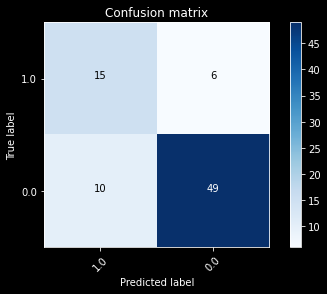

In [144]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

# Accuracy

In [145]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8


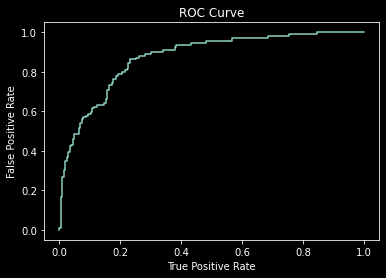

Training set areaUnderROC: 0.87341257287477


In [146]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

# Model Evaluation

In [147]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8248587570621466


## Cross Validation and Parameter Tuning

In [148]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])# regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])# Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])#Number of iterations
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)

# Best Model

## Best Model Performance

In [149]:
## Evaluate Best Model
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.8313155770782887


## Best Model Feature Weights

In [150]:
cvModel.bestModel

LogisticRegressionModel: uid=LogisticRegression_b811a7726d4d, numClasses=2, numFeatures=10

In [151]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
weightsDF.toPandas().head(10)

,Feature Weight
0,-0.347909
1,0.000000
2,0.154975
3,0.184542
4,1.111864
5,0.000000
6,0.229535
7,-0.000000
8,0.257964
9,0.442272


## Best Model Parameters

In [152]:
best_model=cvModel.bestModel

In [153]:
best_model.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 1.0)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: features)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts if fitti